<a href="https://colab.research.google.com/github/ZayedAhmed10/test_demo/blob/master/Core_ML_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Line of best fit example

(0.0, 6.0, 0.0, 20.0)

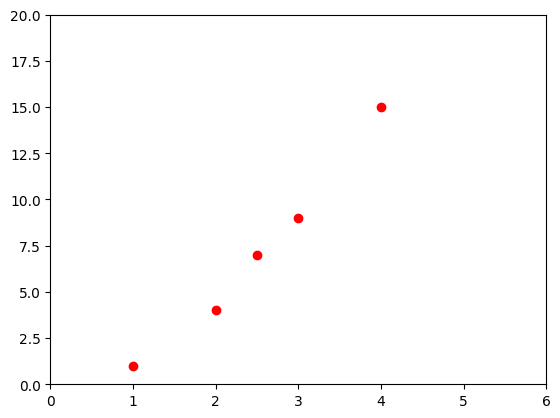

In [ ]:
#for linear pattern between datapoints

import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])

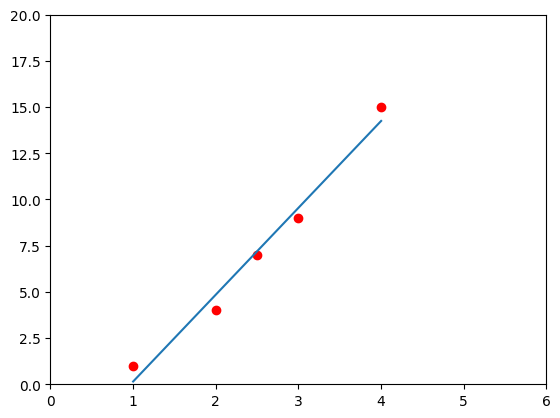

In [ ]:
#plotting line of best fit for the graph
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

**Linear Regression**

Set-ups and imports


In [ ]:
!pip install -q sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
%tensorflow_version 2.x  #(defining the tf version)this line is not required unless you are in a notebook (or not lol)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np #multi-dimensional array calculations
import pandas as pd #manipulate datasets
import matplotlib.pyplot as plt #visualise graphs and charts
from IPython.display import clear_output #just for clearing output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc #feature column needed for linear regression algo

import tensorflow as tf

Data

In [ ]:
# Load titanic dataset for survivors.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

print(dftrain.head()) #get first 5 entries in the dataset

y_train = dftrain.pop('survived') #removing from train dataset and putting the output labels into y_train
y_eval = dfeval.pop('survived') #removing from test dataset and putting the output labels into y_eval

print(dftrain.head()) #get first 5 entries in the dataset


   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0     

In [ ]:
#for a specific row in dataset (here first row):
print(dftrain.loc[0])

print(dftrain["age"]) # for all values of age

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object
0      22.0
1      38.0
2      26.0
3      35.0
4      28.0
       ... 
622    28.0
623    25.0
624    19.0
625    28.0
626    32.0
Name: age, Length: 627, dtype: float64


In [ ]:
#for overall info:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
#get the dataset shape:
dftrain.shape

(627, 9)

let's get some graphs of current dataset to see any correlations in it already

<Axes: >

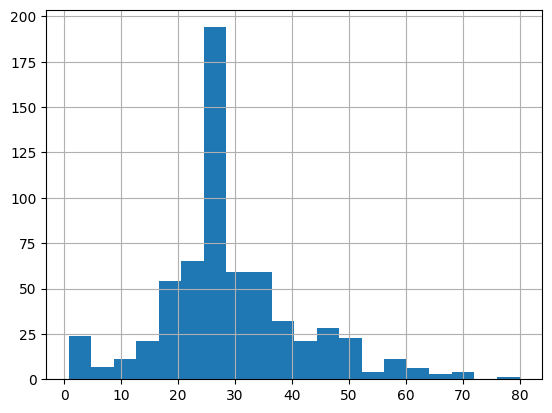

In [ ]:
dftrain.age.hist(bins = 20) #bins = no. of intervals or bars

<Axes: >

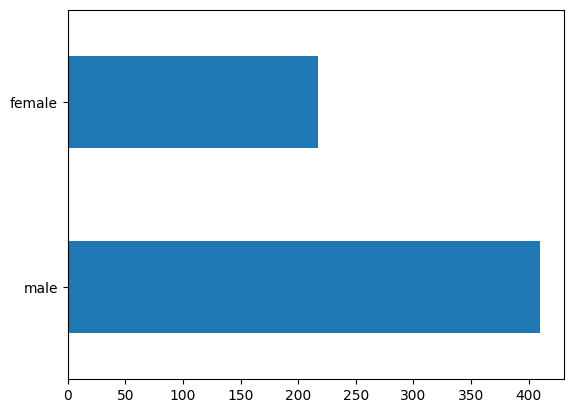

In [ ]:
dftrain["sex"].value_counts().plot(kind="barh")

<Axes: >

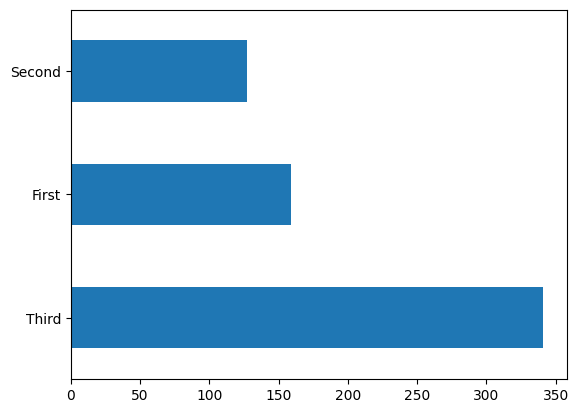

In [ ]:
dftrain["class"].value_counts().plot(kind="barh")

Text(0.5, 0, '% survive')

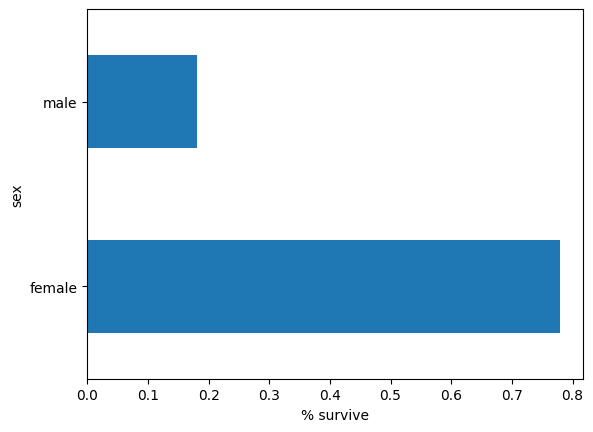

In [ ]:
# percentage survival by sex
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

Train vs Test dataset

In [ ]:
#The training data is what we feed to the model so that it can develop and learn; much larger size than the testing data.
#The testing data is what we use to evaulate the model and see how well it is performing.
print(dftrain.shape)
dfeval.shape

(627, 9)


(264, 9)

Feature columns

In [ ]:
#convert categoric data into numeric data; We can do this by encoding each category with an integer (ex. male = 1, female = 2).
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = [] #gonna be fed to the model to make the predictions
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # .unique() gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) #tf already has this built in function
  #that u can use to create a column of feature_name and the corresponding vocabulary

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
  #for numeric columns, the built in function just takes the name and datatype

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

**The training process** and the input function

In [ ]:
#Ex. if we have 10 ephocs, our model will see the same dataset 10 times. If too many epochs, causes overfitting
#Since we need to feed our data in batches and multiple times, we need to create something called an input function.
#The input function simply defines how our dataset will be converted into batches at each epoch.

#The TensorFlow model we are going to use requires that the data we pass it comes in as a tf.data.Dataset object.
#This means we must create a input function that can convert our current pandas dataframe into that object.

input function defines how the data is broken up into epochs and batches to feed to the model

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us
                                                  # to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) #for testing it no need to have multiple epochs or shuffle


###Creating the Model

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# going to use a linear estimator to utilize the linear regression algorithm (all core algos need estimators)
# We create a linear estimtor by passing the feature columns we created earlier

In [ ]:
#training the model
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.77272725


Now let's see how we can actually use this model to make predicitons.

We can use the .predict() method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set.


In [ ]:
result = list(linear_est.predict(eval_input_fn)) # created dictionary of predictions for all datapoints in eval dataset
print(dfeval.loc[0]) #get the person who is getting predicted
print(result[0]['probabilities'][1]) #looking at first person, their probabilities, and chance of survival
print(y_eval.loc[0]) # see if they actually survived or not

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
0.029628493
0


<Axes: title={'center': 'predicted probabilities'}, ylabel='Frequency'>

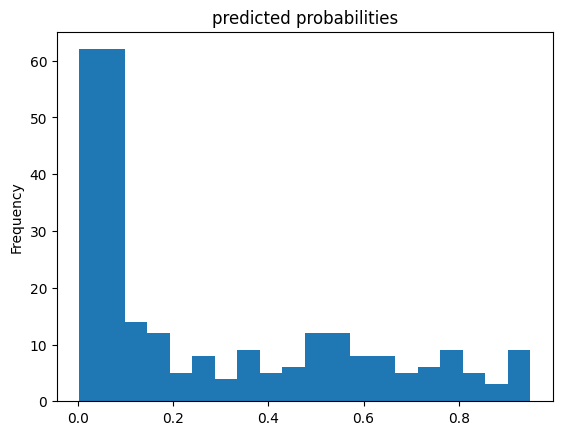

In [ ]:
#let's see the predictions in a histogram
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [ ]:
#let's see the predictions vs real outcome or survival:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])



In [ ]:
fares = dfeval['fare']

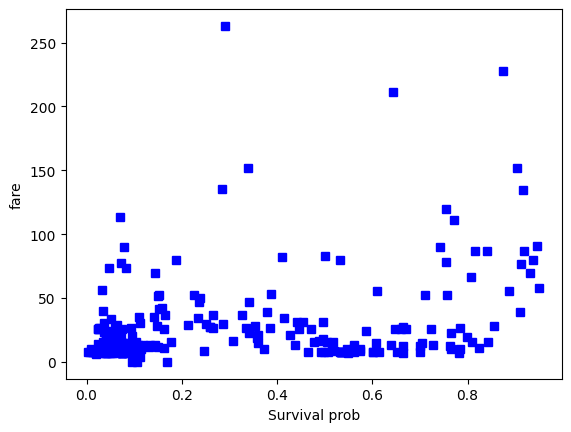

In [ ]:
# Create a scatter plot of how fare relates to if they are predicted to survive
plt.plot(probs, fares, "bs")
plt.xlabel('Survival prob')
plt.ylabel('fare')

# Show the plot
plt.grid(False)
plt.show()

###Classification

classification is used to seperate data points into classes of different labels.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import pandas as pd

###Dataset
This dataset separates flowers into 3 different classes of species.

Setosa,
Versicolor,
Virginica

The information about each flower is the following:
sepal length,
sepal width,
petal length,
petal width

In [ ]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [ ]:
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0) #header=0 means row 0 is the header
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)



573/573 [==============================] - 0s 0us/step


In [ ]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [ ]:
#use the species column as the label (the output) and pop it off the dataset
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is now gone

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [ ]:
train.shape  # we have 120 entires with 4 features

(120, 4)

###Input function
remember to make the input function

In [ ]:
#this one doesnt have epochs!
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()

    return dataset.batch(batch_size)


###Feature columns:

In [ ]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys(): #train.keys gives us all the column names
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

#dont need to .unique() anything as the dataset already made numeric versions of the categoric data

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


###Building the model
For classification tasks there are variety of different estimators/models that we can pick from. Some options are listed below:

DNNClassifier (Deep Neural Network) or LinearClassifier

We can choose either model but the DNN seems to be the best choice. This is because we may not be able to find a linear coorespondence in our data.

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

###Training

In [ ]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000) #steps is similar to epochs, but just means keep going until u hit 5000 things
#lambda is a function, and what is after the colon is what that function does
# We used a lambda here as we didnt create an inner function for the input_function

In [ ]:
#evaluate the model
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

Instructions for updating:
Use tf.keras instead.



Test set accuracy: 0.933



###Predictions
making predictions of new flowers;
the script below allows you to type the features of a flower and see a prediction for its class.

In [ ]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid:
    val = input(feature + ": ") #asks for a prompt for the feature values
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))


Please type numeric values as prompted.
SepalLength: 2.1
SepalWidth: 4.2
PetalLength: 5.1
PetalWidth: 4.6


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


Prediction is "Virginica" (99.6%)


In [ ]:
# Here is some example input and expected classes you can try above
expected = ['Setosa', 'Versicolor', 'Virginica']
predict_x = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

In [ ]:
#now making predictions using already given feature list
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
}

predictions = classifier.predict(input_fn=lambda: input_fn(predict))

for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))

Prediction is "Setosa" (85.3%)
Prediction is "Versicolor" (57.9%)
Prediction is "Virginica" (65.8%)


In [ ]:
print(pred_dict)

{'logits': array([-1.7049285,  2.3998275,  3.0719788], dtype=float32), 'probabilities': array([0.00554433, 0.33614123, 0.65831447], dtype=float32), 'class_ids': array([2]), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2], dtype=int32), 'all_classes': array([b'0', b'1', b'2'], dtype=object)}


###Clustering
involves the grouping of data points
(no way to do it using already built algo)


###Hidden markov models
they go over it but im not doing it here


this is my edit!